In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MAX_ITERS = 10000

In [3]:
def build_state(features):
    """
    Convert a list of single digits, e.g. [1,2,3,4] to 1234
    """
    return int("".join(map(lambda feat: str(int(feat)),features)))

In [4]:
class FeatureTransformer:
    """
    Transforms the features from the states (observation) to a unique (integer)
    feature value representing the state.
    """
    def __init__(self):
        self._cart_position_bins = np.linspace(-2.4,2.4,9)
        self._cart_velocity_bins = np.linspace(-2.0,2.0,9)
        self._pole_angle_bins = np.linspace(-0.4,0.4,9)
        self._pole_velocity_bins = np.linspace(-3.5,3.5,9)

    def transform(self, observation):
        """
        Uses the current observation of the state given by 
        (cart_pos, cart_vel, pol_pos, pol_vel), find the bin index 
        for each feature and return a unique integer value.
        """
        def _which_bin(value, bins):
            """
            Rerturns the bin index containing the value
            """
            return np.digitize(x=[value], bins=bins)[0]
            
        cart_pos, cart_vel, pol_pos, pol_vel = observation
        return build_state([
            _which_bin(cart_pos, self._cart_position_bins),
            _which_bin(cart_vel, self._cart_velocity_bins),
            _which_bin(pol_pos, self._pole_angle_bins),
            _which_bin(pol_vel, self._pole_velocity_bins)
        ])

In [5]:
class Model:
    def __init__(self, env=None, feature_transformer=None):
        
        if not env:
            raise ValueError("env cannot be None. Provide an environment class from gym.")
        self._env = env
        if not feature_transformer:
            raise ValueError("feature_transformer cannot be None.")
        self._feature_transformer = feature_transformer
        self._num_states = self._get_states_count()
        self._num_actions = self._get_actions_count()
        self._Q = self._initialize_Q()
        # used to update Q
        self._alpha = 10e-3

    def predict(self, state):
        x = self._feature_transformer.transform(state)
        return self._Q[x]
    
    def update(self, state, action, G):
        x = self._feature_transformer.transform(state)
        # update Q using gradient descent
        self._Q[x,action] += self._alpha*(G - self._Q[x,action])
        
    def sample_action(self, state, eps):
        """
        Choose an action given current state using epsilon-greedy algorithm
        """
        # choose a random action from the environment
        if np.random.random() < eps: 
            return self._env.action_space.sample()
        else:
            # return Q's for the given state (for different actions)
            # return the argmax of Q
            p = self.predict(state)
            return np.argmax(p)
        
    def _get_states_count(self):
        return 10**self._env.observation_space.shape[0]
    
    def _get_actions_count(self):
        return self._env.action_space.n
    
    def _initialize_Q(self, low=-1, high=1):
        return np.random.uniform(low=low, high=high, size=(self._num_states, self._num_actions))

In [10]:
def play_one_game(model, eps, gamma):
    def _has_lost(done, iters):
        return True if done and iters < 199 else False

    obs = model._env.reset()
    done = False
    iters = 0
    # this is for plotting only.
    total_reward = 0
    while not done and iters < MAX_ITERS:
        action = model.sample_action(obs, eps)
        prev_obs = obs
        obs, reward, done, info = model._env.step(action)
        total_reward += reward
        if _has_lost(done, iters):
            reward = -300
        G = reward + gamma*np.max(model.predict(obs))
        model.update(prev_obs, action, G)
        
        iters += 1

    return total_reward

In [11]:
def plot_running_avg(total_rewards):
    N = len(total_rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [12]:
env = gym.make('CartPole-v0')
featTr = FeatureTransformer()
model = Model(env=env, feature_transformer=featTr)

In [13]:
N = 1000
total_rewards = np.empty(N)
for i in range(N):
    eps = 1.0/np.sqrt(i+1)
    tot_reward = play_one_game(model=model, eps=eps, gamma=0.9)
    total_rewards[i] = tot_reward
    if i % 100 == 0:
        print("episode:{} epsilon:{} total_reward:{}".format(i+1, eps, tot_reward))

episode:1 epsilon:1.0 total_reward:43.0
episode:101 epsilon:0.09950371902099892 total_reward:10.0
episode:201 epsilon:0.07053456158585983 total_reward:126.0
episode:301 epsilon:0.0576390417704235 total_reward:105.0
episode:401 epsilon:0.04993761694389223 total_reward:39.0
episode:501 epsilon:0.04467670516087703 total_reward:33.0
episode:601 epsilon:0.04079085082240021 total_reward:25.0
episode:701 epsilon:0.0377694787300249 total_reward:44.0
episode:801 epsilon:0.03533326266687867 total_reward:156.0
episode:901 epsilon:0.03331483023263848 total_reward:134.0


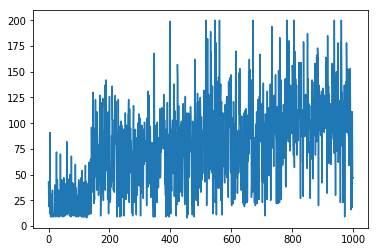

In [14]:
plt.plot(total_rewards)

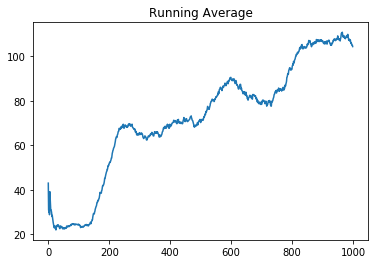

In [15]:
plot_running_avg(total_rewards)

In [30]:
model._Q.shape

(10000, 2)

In [34]:
model._Q[0,1]

0.6591158252760481

In [16]:
model._env.reset()

array([-0.01364755,  0.00694765, -0.01847204, -0.01230216])